In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [48]:
!pip install kaggle
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d hojjatk/mnist-dataset

mkdir: cannot create directory ‘/root/.kaggle’: File exists
cp: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory
Dataset URL: https://www.kaggle.com/datasets/hojjatk/mnist-dataset
License(s): copyright-authors
mnist-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
!unzip mnist-dataset.zip

Archive:  mnist-dataset.zip
  inflating: t10k-images-idx3-ubyte/t10k-images-idx3-ubyte  
  inflating: t10k-images.idx3-ubyte  
  inflating: t10k-labels-idx1-ubyte/t10k-labels-idx1-ubyte  
  inflating: t10k-labels.idx1-ubyte  
  inflating: train-images-idx3-ubyte/train-images-idx3-ubyte  
  inflating: train-images.idx3-ubyte  
  inflating: train-labels-idx1-ubyte/train-labels-idx1-ubyte  
  inflating: train-labels.idx1-ubyte  


In [49]:
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

In [80]:
!pip install numpy
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader, sampler
import torch.nn as nn

train_images_file = np.fromfile('/content/train-images.idx3-ubyte',dtype=np.uint8)
train_labels_file = np.fromfile('/content/train-labels.idx1-ubyte',dtype=np.uint8)
test_images_file = np.fromfile('/content/t10k-images.idx3-ubyte',dtype=np.uint8)
test_labels_file = np.fromfile('/content/t10k-labels.idx1-ubyte',dtype=np.uint8)


In [88]:
import pickle

with open('mnist_data.pickle', 'wb') as f:
    pickle.dump((train_images_file, train_labels_file, test_images_file, test_labels_file), f)

In [89]:
print(len(train_images_file), len(train_labels_file))
print(type(train_images_file[0]))
print(train_labels_file[0])
print(max(train_labels_file), min(train_labels_file))

print(len(test_images_file), len(test_labels_file))
print(type(test_images_file[0]))
print(test_labels_file[0])
print(max(test_labels_file), min(test_labels_file))


32 32
<class 'str'>
/
y -
31 31
<class 'str'>
/
y -


In [102]:
!pip install torchvision
import torchvision
from torchvision import datasets, transforms
class MNIST(Dataset):
  def __init__(self, images_file, labels_file):
    self.data = torchvision.datasets.MNIST(root='./data', train=True, download=True)
    self.images = torch.tensor(self.data.data.numpy(), dtype=torch.float32)
    self.labels = torch.tensor(self.data.targets.numpy(), dtype=torch.long)

  def __len__(self):
    return len(self.images)

  def __getitem__(self, idx):
    return self.images[idx], self.labels[idx]

In [103]:
train_images_file = '/content/train-images.idx3-ubyte'
train_labels_file = '/content/train-labels.idx1-ubyte'
test_images_file = '/content/t10k-images.idx3-ubyte'
test_labels_file = '/content/t10k-labels.idx1-ubyte'


In [104]:
train_data = MNIST(train_images_file, train_labels_file)
test_data = MNIST(test_images_file, test_labels_file)

train_dataloader = DataLoader(train_data, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=10, shuffle=True)

In [105]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_data, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=10, shuffle=True)

for X, y in test_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

Shape of X [N, C, H, W]: torch.Size([10, 28, 28])
Shape of y: torch.Size([10]) torch.int64


In [106]:
class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28*28, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
        )

    def forward(self, x):
        return self.layers(x)

In [107]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = MLP().to(device)
print(model)

MLP(
  (layers): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=1024, bias=True)
    (2): ReLU()
    (3): Linear(in_features=1024, out_features=512, bias=True)
    (4): ReLU()
    (5): Linear(in_features=512, out_features=10, bias=True)
  )
)


In [108]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

In [109]:
def train(data_loader, model, criterion, optimizer):
    model.train()
    total_loss = 0
    total_correct = 0
    num_items = len(data_loader.dataset)

    for data, target in data_loader:
        data, target = data.to(device), target.to(device)


        output = model(data)
        loss = criterion(output, target)


        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


        total_loss += loss.item() * data.size(0)
        pred = output.argmax(dim=1)
        total_correct += pred.eq(target).sum().item()

    avg_loss = total_loss / num_items
    accuracy = 100. * total_correct / num_items
    return avg_loss, accuracy


def test(data_loader, model, criterion):
    model.eval()
    total_loss = 0
    total_correct = 0
    num_items = len(data_loader.dataset)

    with torch.no_grad():
        for data, target in data_loader:
            data, target = data.to(device), target.to(device)

            output = model(data)
            loss = criterion(output, target)

            total_loss += loss.item() * data.size(0)
            pred = output.argmax(dim=1)
            total_correct += pred.eq(target).sum().item()

    avg_loss = total_loss / num_items
    accuracy = 100. * total_correct / num_items
    return avg_loss, accuracy

Epoch 1/10
Train Loss: 0.3938, Train Accuracy: 92.97%
Test Loss: 0.1386, Test Accuracy: 95.78%
Epoch 2/10
Train Loss: 0.1287, Train Accuracy: 96.33%
Test Loss: 0.0955, Test Accuracy: 97.00%
Epoch 3/10
Train Loss: 0.1192, Train Accuracy: 96.67%
Test Loss: 0.0970, Test Accuracy: 97.24%
Epoch 4/10
Train Loss: 0.1136, Train Accuracy: 96.92%
Test Loss: 0.0882, Test Accuracy: 97.39%
Epoch 5/10
Train Loss: 0.1005, Train Accuracy: 97.33%
Test Loss: 0.0845, Test Accuracy: 97.77%
Epoch 6/10
Train Loss: 0.0963, Train Accuracy: 97.55%
Test Loss: 0.1236, Test Accuracy: 97.06%
Epoch 7/10
Train Loss: 0.0808, Train Accuracy: 97.89%
Test Loss: 0.0733, Test Accuracy: 97.97%
Epoch 8/10
Train Loss: 0.0783, Train Accuracy: 98.05%
Test Loss: 0.0543, Test Accuracy: 98.44%
Epoch 9/10
Train Loss: 0.0829, Train Accuracy: 97.94%
Test Loss: 0.0773, Test Accuracy: 97.71%
Epoch 10/10
Train Loss: 0.0845, Train Accuracy: 98.04%
Test Loss: 0.0666, Test Accuracy: 98.30%


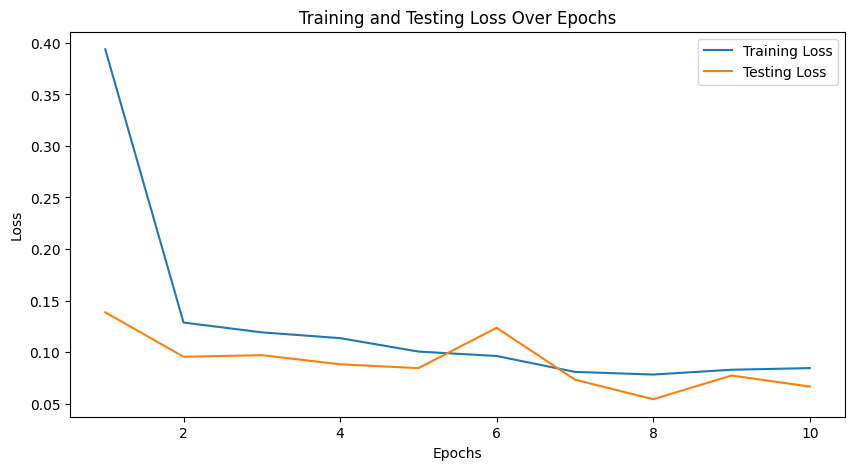

In [110]:
import matplotlib.pyplot as plt

train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

epochs = 10
for epoch in range(epochs):
    print(f"Epoch {epoch+1}/{epochs}")

    train_loss, train_accuracy = train(train_dataloader, model, criterion, optimizer)
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%")

    test_loss, test_accuracy = test(test_dataloader, model, criterion)
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)
    print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")

plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs + 1), train_losses, label='Training Loss')
plt.plot(range(1, epochs + 1), test_losses, label='Testing Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Testing Loss Over Epochs')
plt.legend()
plt.show()
